# DistilBert

### Import necessary packages

In [1]:
import numpy as np
import mlflow
import logging 
import torch 
import config 
import os 
from mlflow.sklearn import save_model
from transformers import AutoModelForSequenceClassification, DistilBertConfig, DistilBertForSequenceClassification,  AutoConfig

# import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import(
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics
)

### Setup

In [3]:
MODEL_NAME = "distilbert-base-uncased" # pulls the general-purpose DistilBERT model
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [4]:
DATA_PATH = "../data/data_small.csv"
# DATA_PATH = "../data/data_tiny.csv" # uncomment this when checking that everything is just running properly. 
MODEL_PATH = "distilbert-base-uncased"
MODEL_TRAINING_PATH ="distilbert-base-uncased"
OUTPUT_DIR = "../models/distilbert_finetuned_1/trainer_output"
SAVE_PATH = "../models/distilbert_finetuned_1/pytorch_model"

### Get data

In [5]:
train_dataset, test_dataset, y_train, le = get_encode_tokenize_data(DATA_PATH, MODEL_PATH)

INFO:basic_functions:Loading data...
INFO:basic_functions:Train test split, test-size 0.3
INFO:root:encode the label column
INFO:root:tokenize
INFO:basic_functions:create tokenizer & load model
INFO:basic_functions:create tokenizer & load model
INFO:root:create TextDatasets (train & test)


### Model Initialization

In [6]:
num_classes = len(np.unique(y_train))
num_classes

6

In [ ]:
# Fine-tuning 2

# # Increase the final dropout to 0.3 for regularization to reduce overfitting.
# new_config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
# new_config.dropout = 0.3  # affects classifier head
# new_config.attention_dropout = 0.2

# trying the automodeldor...., if it doesn't work, I'll try this one:
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=new_config)


In [7]:
model = DistilBertForSequenceClassification.from_pretrained(  # used to be AutoModelForSequenceClassification.from_pretrained
    MODEL_TRAINING_PATH,
    num_labels=num_classes, 
    problem_type="single_label_classification", 
    # config = new_config # This a the new line added after changing the config
)
print(model)

# model.gradient_checkpointing_enable() 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [8]:
# Fine-tuning 1 

# Freeze the first layers. 
for param in model.distilbert.transformer.layer[:1].parameters():
    param.requires_grad = False

In [9]:
params = {
      "learning_rate": 3e-5,
      "weight_decay": 0.01,
      "num_train_epochs": 4,
      "evaluation_strategy": "epoch",
      "class_weight":True,
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "one frozen layers on 2K data")
mlflow.log_params(params)

Active run_id: f9d2cc6b2d564da3ba552439e14d0f64


In [10]:
trainer = createTrainer(
    model= model, 
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    output_dir= OUTPUT_DIR, 
    y_train=y_train, 
    class_weight=True, 
    epochs=4, 
    learning_rate=3e-5, 
    weight_decay = 0.01, 
    train_batch_size=4, 
    eval_batch_size=8 )

INFO:root:defining training arguments
INFO:root:get weighted loss trainer


### Execute Training

In [11]:
torch.mps.empty_cache()  # Clears unused GPU memory

In [12]:
# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [13]:
logger.info('training is running')
trainer.train()

INFO:root:training is running


Epoch,Training Loss,Validation Loss,Accuracy
1,1.285300,1.200440,0.558333
2,0.877900,1.057439,0.611667
3,0.595800,1.105619,0.606667
4,0.288500,1.138714,0.640000


TrainOutput(global_step=1400, training_loss=0.8042706871032714, metrics={'train_runtime': 7239.661, 'train_samples_per_second': 0.774, 'train_steps_per_second': 0.193, 'total_flos': 741870349516800.0, 'train_loss': 0.8042706871032714, 'epoch': 4.0})

### Evaluation


In [14]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

    

INFO:root:predict on test_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                       precision    recall  f1-score   support

           ad_hominem       0.68      0.58      0.63       101
  appeal_to_authority       0.68      0.77      0.72        87
    appeal_to_emotion       0.74      0.49      0.59       101
        false_dilemma       0.88      0.74      0.80       100
faulty_generalization       0.39      0.63      0.48       102
                 none       0.55      0.50      0.52       109

             accuracy                           0.61       600
            macro avg       0.65      0.62      0.62       600
         weighted avg       0.65      0.61      0.62       600

[[59  7  5  2 25  3]
 [ 4 67  3  1  6  6]
 [10  9 49  1 26  6]
 [ 4  1  0 74  6 15]
 [ 6  7  6  4 64 15]
 [ 4  8  3  2 38 54]]


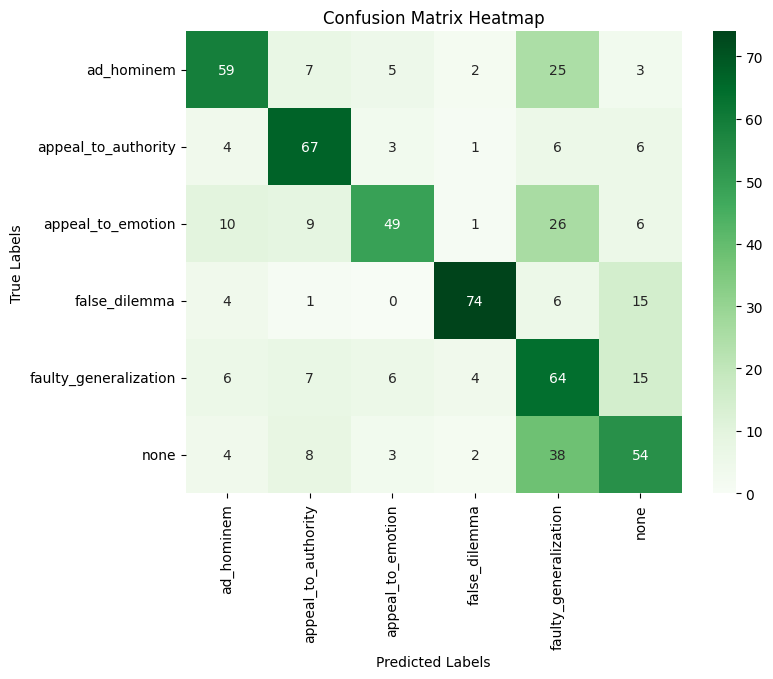

INFO:basic_functions:brier score


Multiclass Brier score: 0.5252020075941234


In [15]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")


INFO:root:predict on train_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                       precision    recall  f1-score   support

           ad_hominem       0.95      0.90      0.93       234
  appeal_to_authority       0.89      0.88      0.89       204
    appeal_to_emotion       0.88      0.82      0.85       235
        false_dilemma       0.97      0.84      0.90       233
faulty_generalization       0.69      0.90      0.78       238
                 none       0.77      0.74      0.75       256

             accuracy                           0.84      1400
            macro avg       0.86      0.85      0.85      1400
         weighted avg       0.86      0.84      0.85      1400

[[211   1  11   1   7   3]
 [  1 180   3   0   9  11]
 [  7   9 192   0  15  12]
 [  1   0   1 195  19  17]
 [  0   3   5   2 215  13]
 [  1   9   7   4  46 189]]


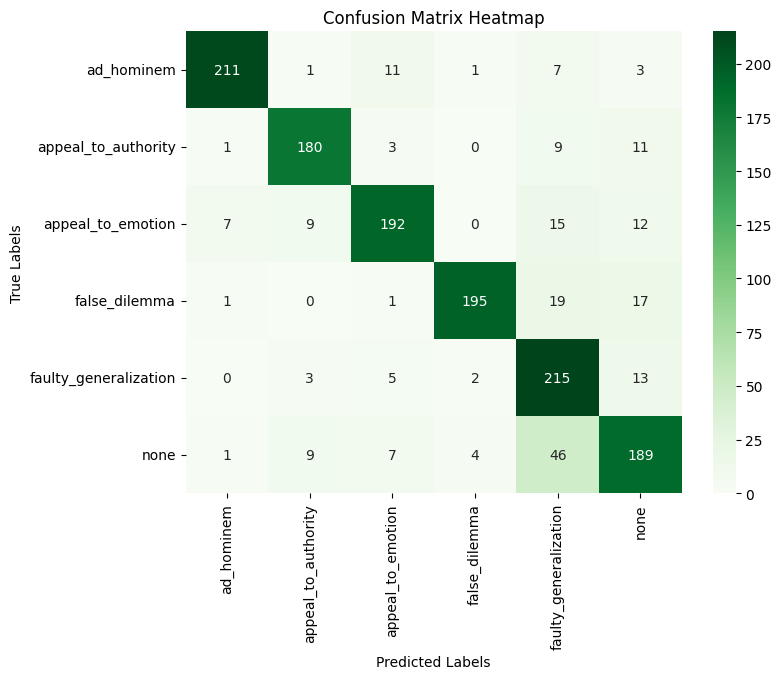

INFO:basic_functions:brier score


Multiclass Brier score: 0.2450823729469428


In [16]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")


In [ ]:
mlflow.end_run()

### Save model

In [ ]:
# #save with pytorch
# mlflow.pytorch.save_model(model, path=SAVE_PATH)